In [1]:
# Package Setup
import Pkg;
# Pkg.update()

# Julia Packages
using Distributions
using LinearAlgebra
using Statistics
using PGFPlots

# Satellite Dynamics Packages
using SatelliteDynamics

# Load SatelliteTasking - Reclone to keep version current
Pkg.clone("..") # For some reason this doens't work with Pkg.add + PackageSpec. Why?
using SatelliteTasking
using SatelliteTasking.SatellitePlanning
using SatelliteTasking.Analysis

# Temporary for now
Pkg.add("JuMP")
Pkg.add("Gurobi")
using JuMP
using Gurobi

┌ Warning: Pkg.clone is only kept for legacy CI script reasons, please use `add`
└ @ Pkg.API /Users/osx/buildbot/slave/package_osx64/build/usr/share/julia/stdlib/v1.1/Pkg/src/API.jl:386


 Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]


┌ Info: Precompiling SatelliteTasking [30f2e302-0ae1-11e9-1cda-0f4324764595]
└ @ Base loading.jl:1186


  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]


In [2]:
# Figure 1 Setup - Orbit Altitude Effect on Window Duration

@time images = load_images("../data/landsat_test.json", dwell_time=5.0);

mean_duration = Tuple{Float64, Float64}[]

num_orbits = 10

@time for alt in 400:50:1000
    println("Computing mean observation duration for $alt km altitude orbit.")
    
    # Configure simulation
    epc0 = Epoch(2019, 1, 1, 0, 0, 0, tsys=:UTC) # Start of time span
    epcf = Epoch(2019, 1, 2, 0, 0, 0, tsys=:UTC) # End of simulation time span

    # Set Simulation Time Step
    timestep = 1
    dtmax    = 5

    # Define Satellite Orbit
    oe   = [R_EARTH + alt*1e3, 0, 90.0, 0, 0, 0]
    eci0 = sOSCtoCART(oe, use_degrees=true)

    # Numer of perturbed orbits to simulate

    # Set Perturbation Values 
    pos_error = 5000 # Position knowledge error [m]
    vel_error = 5    # Velocity knowledge error [m/s]
    orb_mean  = zeros(Float64, 6)
    orb_sdev  = vcat((pos_error/sqrt(3)*ones(Float64, 3))..., (vel_error/sqrt(3)*ones(Float64, 3))...)

    # Simulate true and perturbed orbits
    true_orbit, perturbed_orbits, eci_errors = simulate_orbits(num_orbits, epc0, epcf, eci0, orb_mean, orb_sdev, timestep=timestep, dtmax=dtmax);
    
    true_opportunities, perturbed_opportunities, mean_diff, sdev_diff, missing_opportunities = compute_perturbed_opportunities(true_orbit, perturbed_orbits, images, epc_step=3600);
    
    all_opportunities = sort!(vcat(perturbed_opportunities...), by = x -> x.sow)
    
    md = mean([opp.duration for opp in all_opportunities])
    
    push!(mean_duration, (alt, md))
end

  0.560647 seconds (1.24 M allocations: 64.705 MiB, 6.25% gc time)
Computing mean observation duration for 400 km altitude orbit.
Simulating perturbed orbit 1
Simulating perturbed orbit 2
Simulating perturbed orbit 3
Simulating perturbed orbit 4
Simulating perturbed orbit 5
Simulating perturbed orbit 6
Simulating perturbed orbit 7
Simulating perturbed orbit 8
Simulating perturbed orbit 9
Simulating perturbed orbit 10
Computing opportunities for perturbed orbit: 1
Computing opportunities for perturbed orbit: 2
Computing opportunities for perturbed orbit: 3
Computing opportunities for perturbed orbit: 4
Computing opportunities for perturbed orbit: 5
Computing opportunities for perturbed orbit: 6
Computing opportunities for perturbed orbit: 7
Computing opportunities for perturbed orbit: 8
Computing opportunities for perturbed orbit: 9
Computing opportunities for perturbed orbit: 10
Computing mean observation duration for 450 km altitude orbit.
Simulating perturbed orbit 1
Simulating pertu

Computing opportunities for perturbed orbit: 9
Computing opportunities for perturbed orbit: 10
Computing mean observation duration for 900 km altitude orbit.
Simulating perturbed orbit 1
Simulating perturbed orbit 2
Simulating perturbed orbit 3
Simulating perturbed orbit 4
Simulating perturbed orbit 5
Simulating perturbed orbit 6
Simulating perturbed orbit 7
Simulating perturbed orbit 8
Simulating perturbed orbit 9
Simulating perturbed orbit 10
Computing opportunities for perturbed orbit: 1
Computing opportunities for perturbed orbit: 2
Computing opportunities for perturbed orbit: 3
Computing opportunities for perturbed orbit: 4
Computing opportunities for perturbed orbit: 5
Computing opportunities for perturbed orbit: 6
Computing opportunities for perturbed orbit: 7
Computing opportunities for perturbed orbit: 8
Computing opportunities for perturbed orbit: 9
Computing opportunities for perturbed orbit: 10
Computing mean observation duration for 950 km altitude orbit.
Simulating pertur

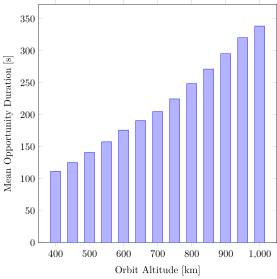

In [3]:
# Figure 1 Render 
a1 = Axis([
    Plots.Linear(collect([md[1] for md in mean_duration]), collect([md[2] for md in mean_duration]))
], width="10cm", height="10cm", xmin=350, xmax=1050, ymin=0, style="ybar", 
    xlabel="Orbit Altitude [km]", ylabel="Mean Opportunity Duration [s]")

save("ijcai_figures/orbit_altitude.tex", a1, include_preamble=false)
a1

In [4]:
# Figure 1 Setup - Effect of Estimation Errors On Opportunities

@time images = load_images("../data/landsat_test_600.json", dwell_time=5.0);

mean_duration = Tuple{Float64, Float64}[]

num_orbits = 5

# Configure simulation
epc0 = Epoch(2019, 1, 1, 0, 0, 0, tsys=:UTC) # Start of time span
epcf = Epoch(2019, 1, 2, 0, 0, 0, tsys=:UTC) # End of simulation time span

# Set Simulation Time Step
timestep = 1
dtmax    = 5

# Define Satellite Orbit
oe   = [R_EARTH + 550*1e3, 0, 90.0, 0, 0, 0]
eci0 = sOSCtoCART(oe, use_degrees=true)

# Simulate 1m Error

pos_errors = [1, 10, 100, 1000, 2500, 5000]

true_orbits_array      = Orbit[]
perturbed_orbits_array = Array{Orbit,1}[]
eci_errors_array       = Array{Float64, 2}[]

true_opportunities_array      = Array{Opportunity,1}[]
perturbed_opportunities_array = Array{Array{Opportunity,1},1}[]
mean_diff_array               = Array{Float64,2}[]
sdev_diff_array               = Array{Float64,2}[]
missing_opportunities_array   = Array{Int64, 1}[]

@time for i in 1:length(pos_errors)
    perr = pos_errors[i]
    verr = perr/1000
    println("Simulating Error set $i - $perr m, $verr m/s")
    
    orb_mean  = zeros(Float64, 6)
    orb_sdev  = vcat((perr/sqrt(3)*ones(Float64, 3))..., (verr/sqrt(3)*ones(Float64, 3))...)

    
    true_orbit_i, perturbed_orbits_i, eci_errors_i = simulate_orbits(num_orbits, epc0, epcf, eci0, orb_mean, orb_sdev, timestep=timestep, dtmax=dtmax);
    true_opportunities_i, perturbed_opportunities_i, mean_diff_i, sdev_diff_i, missing_opportunities_i = compute_perturbed_opportunities(true_orbit_i, perturbed_orbits_i, images, epc_step=3600);
    
    push!(true_orbits_array, true_orbit_i)
    push!(perturbed_orbits_array, perturbed_orbits_i)
    push!(eci_errors_array, eci_errors_i)
    
    push!(true_opportunities_array, true_opportunities_i)
    push!(perturbed_opportunities_array, perturbed_opportunities_i)
    push!(mean_diff_array, mean_diff_i)
    push!(sdev_diff_array, sdev_diff_i)
    push!(missing_opportunities_array, missing_opportunities_i)
end

  0.007108 seconds (23.73 k allocations: 1.382 MiB)
Simulating Error set 1 - 1 m, 0.001 m/s
Simulating perturbed orbit 1
Simulating perturbed orbit 2
Simulating perturbed orbit 3
Simulating perturbed orbit 4
Simulating perturbed orbit 5
Computing opportunities for perturbed orbit: 1
Computing opportunities for perturbed orbit: 2
Computing opportunities for perturbed orbit: 3
Computing opportunities for perturbed orbit: 4
Computing opportunities for perturbed orbit: 5
Simulating Error set 2 - 10 m, 0.01 m/s
Simulating perturbed orbit 1
Simulating perturbed orbit 2
Simulating perturbed orbit 3
Simulating perturbed orbit 4
Simulating perturbed orbit 5
Computing opportunities for perturbed orbit: 1
Computing opportunities for perturbed orbit: 2
Computing opportunities for perturbed orbit: 3
Computing opportunities for perturbed orbit: 4
Computing opportunities for perturbed orbit: 5
Simulating Error set 3 - 100 m, 0.1 m/s
Simulating perturbed orbit 1
Simulating perturbed orbit 2
Simulating

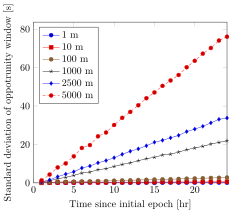

In [5]:
# Figure 2 Render - Effect of Estimation Errors On Opportunities

# a2 = Axis(collect([
#     Plots.Linear(1:24, sdev_diff_array[i][1, :], legendentry="sti - i m") for i in 1:length(pos_errors)
# ]),legendPos="north west", xmin=0, xmax=24, ymin=0, 
#     xlabel="Time since initial epoch [hr]", 
#     ylabel="Standard deviation of oppotrunity window [s]")

a2 = Axis([
    Plots.Linear(1:24, sdev_diff_array[1][1, :], legendentry="1 m")
    Plots.Linear(1:24, sdev_diff_array[2][1, :], legendentry="10 m")
    Plots.Linear(1:24, sdev_diff_array[3][1, :], legendentry="100 m")
    Plots.Linear(1:24, sdev_diff_array[4][1, :], legendentry="1000 m")
    Plots.Linear(1:24, sdev_diff_array[5][1, :], legendentry="2500 m")
    Plots.Linear(1:24, sdev_diff_array[6][1, :], legendentry="5000 m")
],legendPos="north west", xmin=0, xmax=24, ymin=0, 
    xlabel="Time since initial epoch [hr]", 
    ylabel="Standard deviation of oppotrunity window [s]")


# a2 = Axis([
#     Plots.Linear(1:24, sdev_diff_array[1][1, :], legendentry="st - 1 m")
#     Plots.Linear(1:24, sdev_diff_array[1][2, :], legendentry="et - 1 m")
#     Plots.Linear(1:24, sdev_diff_array[2][1, :], legendentry="st - 10 m")
#     Plots.Linear(1:24, sdev_diff_array[2][2, :], legendentry="et - 10 m")
#     Plots.Linear(1:24, sdev_diff_array[3][1, :], legendentry="st - 1000 m")
#     Plots.Linear(1:24, sdev_diff_array[3][2, :], legendentry="et - 5 km")
# ],legendPos="north west", xmin=0, xmax=24, ymin=0, 
#     xlabel="Time since initial epoch [hr]", 
#     ylabel="Standard deviation of oppotrunity window [s]")

save("ijcai_figures/window_difference.tex", a2, include_preamble=false)
a2

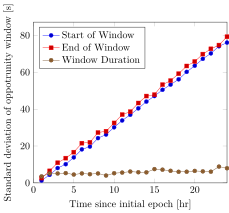

In [7]:
a3 = Axis([
    Plots.Linear(1:24, sdev_diff_array[6][1, :], legendentry="Start of Window")
    Plots.Linear(1:24, sdev_diff_array[6][2, :], legendentry="End of Window")
    Plots.Linear(1:24, sdev_diff_array[6][3, :], legendentry="Window Duration")
#     Plots.Linear(1:24, missing_opportunities_1m, legendentry="Number of Missing Opportunities")
], legendPos="north west", xmin=0, xmax=24, ymin=0, 
    xlabel="Time since initial epoch [hr]", 
    ylabel="Standard deviation of oppotrunity window [s]")
    
save("ijcai_figures/tle_window_difference.tex", a3, include_preamble=false)
a3

In [9]:
println(sdev_diff_array[6][1,:])
println(sdev_diff_array[6][2,:])

[1.30461, 4.35703, 8.04623, 10.1366, 13.829, 18.1827, 19.6875, 24.2693, 26.2147, 30.1368, 33.837, 36.9261, 40.4077, 44.0643, 47.0567, 50.4618, 53.2835, 56.1425, 60.1787, 63.5115, 67.2453, 70.1944, 74.0644, 76.0438]
[2.61977, 6.5219, 10.9182, 13.428, 16.6668, 21.5353, 22.0005, 27.289, 28.0074, 32.4997, 37.0256, 38.6023, 43.2977, 47.0667, 47.8194, 53.2502, 55.4431, 59.1903, 63.3636, 65.8041, 69.8047, 72.6558, 74.6914, 79.2167]
[-0.239344, -0.657895, -1.03697, -0.926966, -0.801386, -1.1551, -0.235294, -0.615248, -0.35122, -0.430493, -0.800373, -0.384868, -0.844595, -0.755102, 0.582222, -0.351515, 0.025974, -0.82397, -0.62069, -0.666667, -0.538462, -0.722222, 0.0124611, -0.610329]


In [ ]:
@profile m